In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [43]:
os.chdir('/Users/aladelca/Library/CloudStorage/OneDrive-McGillUniversity/MMA/Enterprise Data Science/repo/enterprise_data_science/')

## Read data    

In [45]:
data_path = 'https://raw.githubusercontent.com/aladelca/enterprise_data_science/main/data_extract/players_all.csv'
data_path = 'data_extract/players_all.csv'
data = pd.read_csv(data_path, index_col=0)
print(data.shape)
data.head()

(5100, 78)


,name,Age,Overall rating,Potential,Team & Contract,ID,Height,Weight,foot,Best overall,Best position,Growth,Joined,Loan date end,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,Weak foot,Skill moves,Attacking work rate,Defensive work rate,International reputation,Body type,Real face,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Traits,PlayStyles,PlayStyles +,Number of playstyles,Unnamed: 78
0,Vini Jr. LW ST,22,89,94,Real Madrid\n2018 ~ 2027,238794,"176cm / 5'9""",73kg / 161lbs,Right,89,LW,5,"Jul 12, 2018",NaN,€158.5M,€310K,€336.8M,369,78,89,50,80,72,398,92,77,62,77,90,454,95,95,94,86,84,378,76,74,84,64,80,317,58,26,87,81,65,79,75,32,25,18,36,5,7,7,7,10,2027,442,4,5,High,High,5,Lean (170-185),Yes,95,82,78,90,29,68,NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,7,NaN
1,A. Lunin GK,24,76+2,83+2,Real Madrid\n2018 ~ 2024,243952,"191cm / 6'3""",83kg / 183lbs,Right,76,GK,7,"Jul 2, 2018",NaN,€13M,€67K,€29.3M,72,15,8,12,25,12,81,11,14,15,26,15,210,39,35,36,75+2,25,217,56+2,61+1,32,61,7,131,22,19,11,60,19,56,46,22,13,11,375,76+2,73+2,74+2,75+2,77+2,1132,412,3,1,Medium,Medium,1,Normal (185+),Yes,76,73,74,77,37,75,NaN,Footwork Rush Out,NaN,2,NaN
2,J. Bellingham CAM CM,20,87,92,Real Madrid\n2023 ~ 2029,252371,"186cm / 6'1""",75kg / 165lbs,Right,89,CAM,5,"Jul 1, 2023",NaN,€118.5M,€190K,€251.8M,383,66,86,69,88,74,388,87,73,56,86,86,402,78,76,81,88,79,407,79,80,93,75,80,404,85,82,87,86,64,85,233,77,79,77,48,14,11,10,5,8,2265,486,4,4,High,High,4,Lean (185+),Yes,77,82,81,86,78,82,NaN,Intercept Slide Tackle Technical Flair,Relentless +,5,NaN
3,R. Højlund ST,20,77,89,Manchester United\n2023 ~ 2028,259399,"191cm / 6'3""",79kg / 174lbs,Left,79,ST,12,"Aug 5, 2023",NaN,€25.5M,€77K,€53.6M,325,38,78,70,71+1,68,306,76+1,58,48,49,75-1,380,84,86,69,78+3,63,403,82+4,88,78+3,85,70,322,82+2,28,79+1,63+5,70,75+3,79,32+5,28,19,50,12,8,9,14,7,1865,409,3,3,Medium,High,1,Normal (185+),No,85,76,58,74,33,83,NaN,Rapid Flair Quick Step,NaN,3,NaN
4,K. Havertz CAM RW ST,24,82,87,Arsenal\n2023 ~ 2028,235790,"190cm / 6'3""",82kg / 181lbs,Left,85,CAM,5,"Jun 28, 2023",NaN,€46M,€110K,€88.6M,398,74,81,80,83,80,385,84,84,53,79,85,382,75,81,75,83,68,382,76,82,77,69,78,327,52,38,83,81,73,84,123,39,46,38,47,6,8,11,10,12,2044,432,4,4,Medium,Medium,3,Unique,Yes,78,79,79,83,45,68,NaN,Chip Shot Technical First Touch Trivela,NaN,4,NaN


## Data cleaning

In [46]:
## Constants
FINAL_COLUMNS = [
    'Age',
    'foot',
    'wage_euros',
    'release_clause_euros',
    'Best overall',
    'Best position',
    'Growth',
    'Total attacking',
    'Total skill',
    'Total movement',
    'Total power',
    'Total mentality',
    'Total defending',
    'Total goalkeeping',
    'Total stats',
    'Base stats',
    'Weak foot',
    'Skill moves',
    'Defensive work rate',
    'International reputation',
    'Body type',
    'Pace / Diving',
    'Shooting / Handling',
    'Dribbling / Reflexes',
    'Defending / Pace',
    'Physical / Positioning',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'Number of playstyles',
    'height_cm',
    'weight_kg',
    'club',
    'loan',
    'total_potential',
    'contract_duration_years',
    'contract_years_left',
    'total_crossing',
    'total_finishing',
    'total_heading_accuracy',
    'total_short_passing',
    'total_volleys',
    'total_dribbling',
    'total_curve',
    'total_fk_accuracy',
    'total_long_passing',
    'total_ball_control',
    'total_acceleration',
    'total_sprint_speed',
    'total_agility',
    'total_reactions',
    'total_balance',
    'total_shot_power',
    'total_jumping',
    'total_stamina',
    'total_strength',
    'total_long_shots',
    'total_aggression',
    'total_interceptions',
    'total_att__position',
    'total_vision',
    'total_penalties',
    'total_composure',
    'total_defensive_awareness',
    'total_standing_tackle',
    'total_gk_diving',
    'total_gk_handling',
    'total_gk_positioning',
    'total_gk_reflexes',
    'total_overall_rating'
]

columns = [
    'Crossing',
    'Potential',
    'Finishing',
    'Heading accuracy',
    'Short passing',
    'Volleys',
    'Dribbling',
    'Curve',
    'FK Accuracy',
    'Long passing',
    'Ball control',
    'Acceleration',
    'Sprint speed',
    'Agility',
    'Reactions',
    'Balance',
    'Shot power',
    'Jumping',
    'Stamina',
    'Strength',
    'Long shots',
    'Aggression',
    'Interceptions',
    'Att. Position',
    'Vision',
    'Penalties',
    'Composure',
    'Defensive awareness',
    'Standing tackle',
    'GK Diving',
    'GK Handling',
    'GK Kicking',
    'GK Positioning',
    'GK Reflexes',
    'Overall rating'
]

TARGET = [
    'value_euros',
    ]
CAT_VARIABLES = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan'
]

NUM_VARIABLES = list(set(FINAL_COLUMNS) - set(CAT_VARIABLES))

In [47]:
### Data cleaning

def get_height(data):
    df_height = data['Height'].str.split('/', expand=True)
    df_height.columns = ['height_cm','height_inch']
    data['height_cm'] = df_height['height_cm'].str.replace('cm','')
    data['height_cm'] = data['height_cm'].astype(int) 
    return data

def get_weight(data):
    df_weight = data['Weight'].str.split('/', expand=True)
    df_weight.columns = ['weight_kg','height_lbs']
    data['weight_kg'] = df_weight['weight_kg'].str.replace('kg','')
    data['weight_kg'] = data['weight_kg'].astype(int) 
    return data

def extract_year(string):
    try:
        match = re.search(r'\b\d{4}\b', string)
        year_extracted = match.group()
        return year_extracted
    except:
        return string

def manage_currency(column_name,final_column_name, data):
    data[column_name] = data[column_name].str.replace('€','')
    data['factor'] = np.where(data[column_name].str.contains('M'),1000000, np.where(data[column_name].str.contains('K'),1000,1))
    data[column_name] = data[column_name].str.replace('M','')
    data[column_name] = data[column_name].str.replace('K','')
    data[column_name] = data[column_name].astype(float)
    data[final_column_name] = data['factor'] * data[column_name]
    return data

def fill_columns(column_name, new_column_name, data):

    df_potential = data[column_name].str.split('[-,+]', expand=True).fillna(0).astype(int)
    data[new_column_name] = df_potential[0] + df_potential[1]
    return data

def get_contract_team_variables(current_year,data):
    df_club = data['Team & Contract'].str.split('\n', expand = True)
    df_club.columns = ['club','contract']
    data['club'] = df_club['club']
    data['loan'] = df_club['contract'].str.contains('On loan')
    df_club['contract_end'] = df_club['contract'].apply(lambda x: extract_year(x) if 'On loan' in x else x)
    df_contract = df_club['contract_end'].str.split('~', expand = True)
    df_contract.columns = ['start','end']
    df_contract['end'] = np.where(df_contract['end'].isna(),df_contract['start'], df_contract['end'])
    data['contract_end'] = df_contract['end']
    data['contract_start'] = data['Joined'].apply(lambda x: extract_year(x))
    data['contract_end'] = data['contract_end'].str.strip()
    data['contract_end'] = np.where(data['contract_end'] == 'Free','', data['contract_end'])
    data['contract_end'] = data['contract_end'].replace('',np.nan)
    data['contract_end'] = data['contract_end'].astype(float)
    data['contract_duration_years'] = data['contract_end'] - data['contract_start'].astype(float)
    data['contract_years_left'] = np.where(data['contract_end'] - 2024>=0, data['contract_end'] - current_year, np.nan)
    return data

def get_total_values(data, columns):
    for i in columns:
        new_column = 'total_'+i.lower()
        new_column = new_column.replace(' ','_')
        new_column = new_column.replace('.','_')
        data = fill_columns(i,new_column,data)
    return data

def get_final_columns(data, columns):
    data = data[columns]
    return data

def data_preprocess(data):
    
    data = get_height(data)
    data = get_weight(data)
    data = manage_currency('Value','value_euros',data)
    data = manage_currency('Wage','wage_euros',data)
    data = manage_currency('Release clause','release_clause_euros',data)
    data = get_contract_team_variables(2024, data)
    data = get_total_values(data, columns)
    data = get_final_columns(data,FINAL_COLUMNS + TARGET)
    return data



In [48]:
data = data_preprocess(data)
data.head()

,Age,foot,wage_euros,release_clause_euros,Best overall,Best position,Growth,Total attacking,Total skill,Total movement,Total power,Total mentality,Total defending,Total goalkeeping,Total stats,Base stats,Weak foot,Skill moves,Defensive work rate,International reputation,Body type,Pace / Diving,Shooting / Handling,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Traits,PlayStyles,PlayStyles +,Number of playstyles,height_cm,weight_kg,club,loan,total_potential,contract_duration_years,contract_years_left,total_crossing,total_finishing,total_heading_accuracy,total_short_passing,total_volleys,total_dribbling,total_curve,total_fk_accuracy,total_long_passing,total_ball_control,total_acceleration,total_sprint_speed,total_agility,total_reactions,total_balance,total_shot_power,total_jumping,total_stamina,total_strength,total_long_shots,total_aggression,total_interceptions,total_att__position,total_vision,total_penalties,total_composure,total_defensive_awareness,total_standing_tackle,total_gk_diving,total_gk_handling,total_gk_positioning,total_gk_reflexes,total_overall_rating,value_euros
0,22,Right,310000.0,336800000.0,89,LW,5,369,398,454,378,317,75,36,2027,442,4,5,High,5,Lean (170-185),95,82,90,29,68,NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,7,176,73,Real Madrid,False,94,9.0,3.0,78,89,50,80,72,92,77,62,77,90,95,95,94,86,84,76,74,84,64,80,58,26,87,81,65,79,32,25,5,7,7,10,89,158500000.0
1,24,Right,67000.0,29300000.0,76,GK,7,72,81,210,217,131,46,375,1132,412,3,1,Medium,1,Normal (185+),76,73,77,37,75,NaN,Footwork Rush Out,NaN,2,191,83,Real Madrid,False,85,6.0,0.0,15,8,12,25,12,11,14,15,26,15,39,35,36,77,25,58,62,32,61,7,22,19,11,60,19,56,22,13,78,75,77,79,78,13000000.0
2,20,Right,190000.0,251800000.0,89,CAM,5,383,388,402,407,404,233,48,2265,486,4,4,High,4,Lean (185+),77,82,86,78,82,NaN,Intercept Slide Tackle Technical Flair,Relentless +,5,186,75,Real Madrid,False,92,6.0,5.0,66,86,69,88,74,87,73,56,86,86,78,76,81,88,79,79,80,93,75,80,85,82,87,86,64,85,77,79,14,11,5,8,87,118500000.0
3,20,Left,77000.0,53600000.0,79,ST,12,325,306,380,403,322,79,50,1865,409,3,3,High,1,Normal (185+),85,76,74,33,83,NaN,Rapid Flair Quick Step,NaN,3,191,79,Manchester United,False,89,5.0,4.0,38,78,70,72,68,77,58,48,49,76,84,86,69,81,63,86,88,81,85,70,84,28,80,68,70,78,37,28,12,8,14,7,77,25500000.0
4,24,Left,110000.0,88600000.0,85,CAM,5,398,385,382,382,327,123,47,2044,432,4,4,Medium,3,Unique,78,79,83,45,68,NaN,Chip Shot Technical First Touch Trivela,NaN,4,190,82,Arsenal,False,87,5.0,4.0,74,81,80,83,80,84,84,53,79,85,75,81,75,83,68,76,82,77,69,78,52,38,83,81,73,84,39,46,6,8,10,12,82,46000000.0


## Split datasets into Train and Validation

In [59]:
from sklearn.model_selection import train_test_split

x = data[FINAL_COLUMNS]
y = data[TARGET]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=123)

train = pd.concat([x_train, y_train], axis = 1)



## Exploratory data analysis

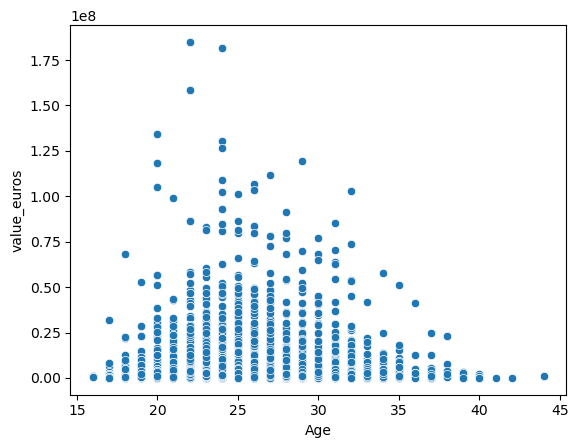

In [60]:
sns.scatterplot(data = train, x = 'Age', y = 'value_euros')
plt.show()

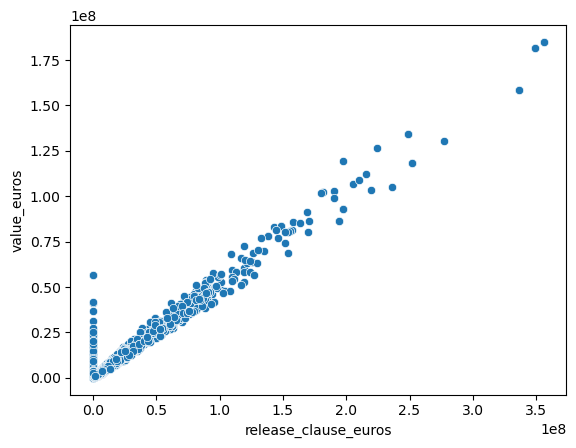

In [86]:
sns.scatterplot(data = train, x = 'release_clause_euros', y = 'value_euros')
plt.show()

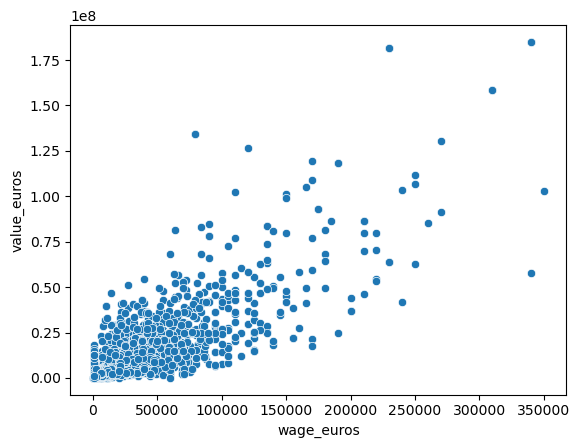

In [62]:
sns.scatterplot(data = train, x = 'wage_euros', y = 'value_euros')
plt.show()

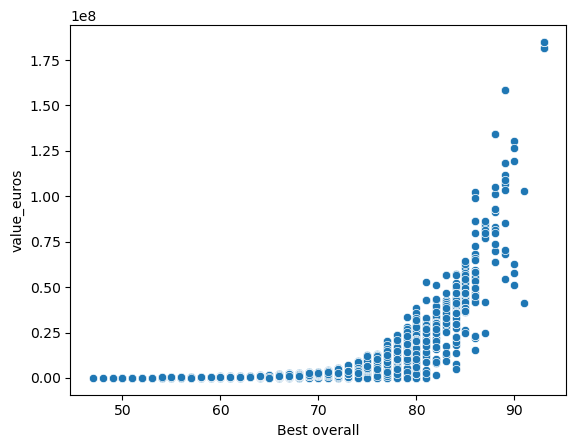

In [63]:
sns.scatterplot(data = train, x = 'Best overall', y = 'value_euros')
plt.show()

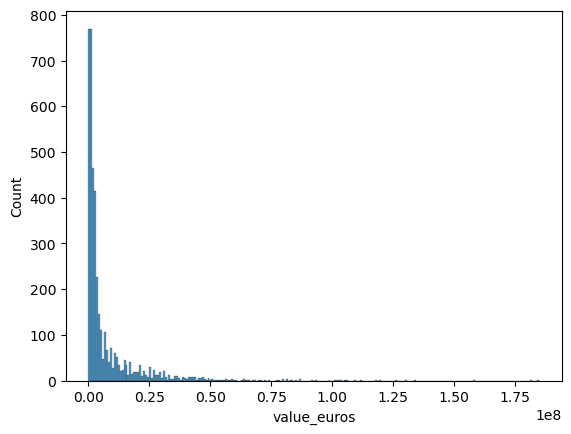

In [76]:
sns.histplot(data = train, x = 'value_euros')
plt.show()

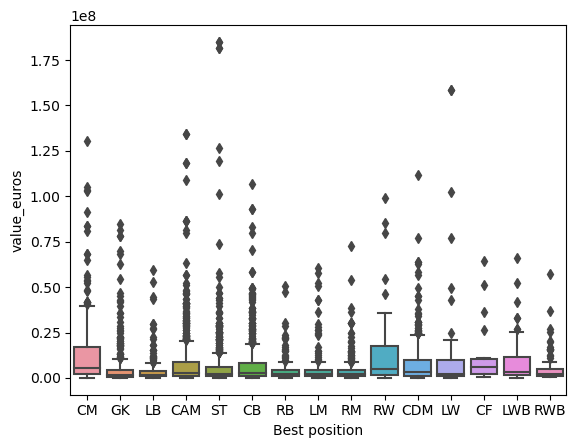

In [79]:
sns.boxplot(data = train, y = 'value_euros', x = 'Best position')
plt.show()

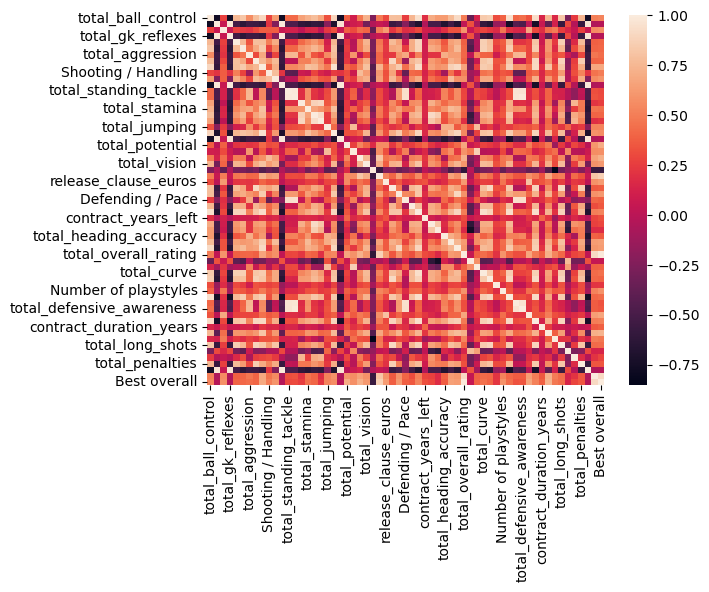

In [64]:
#plt.figure(figsize = (20,20))
sns.heatmap(train[NUM_VARIABLES].corr())
plt.show()

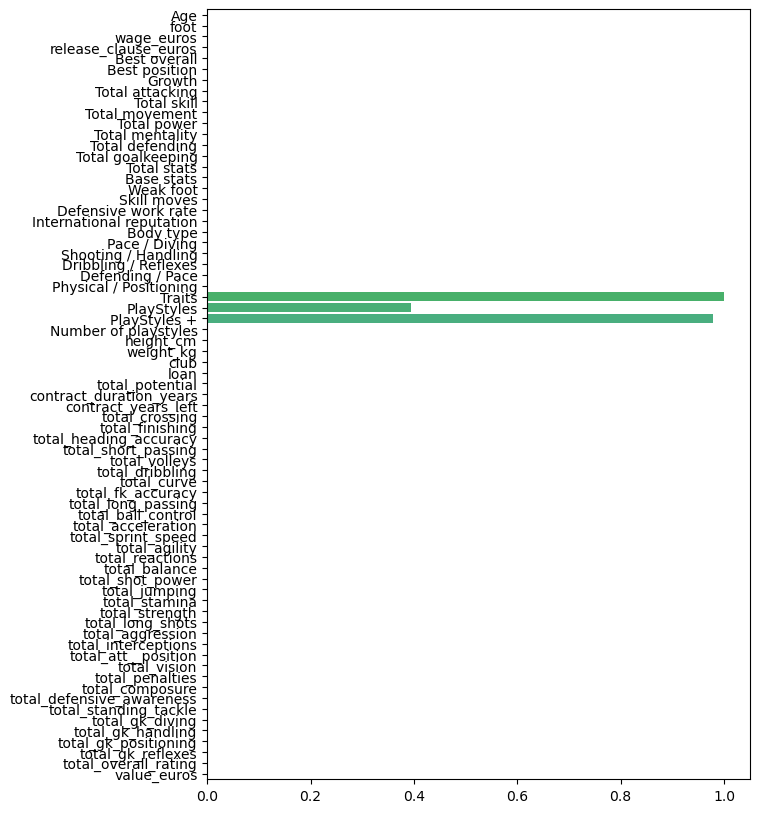

In [84]:
plt.figure(figsize = (7,10))
sns.barplot(x = train.isna().mean().values, y = train.isna().mean().index)
plt.show()

In [83]:
## Filtering players without current contract

train = train[~train['contract_years_left'].isna()]

## Scalling

In [89]:
from sklearn.preprocessing import StandardScaler

esc = StandardScaler()
train_esc = esc.fit_transform(train[NUM_VARIABLES])

## Applying PCA

In [91]:
from sklearn.decomposition import PCA

components = np.arange(1,11)
for i in components:
    pca = PCA(n_components=i)
    pca.fit(train_esc)
    print(np.sum(pca.explained_variance_ratio_))

0.43513033601805584
0.5797380786129072
0.7061076569555698
0.7619085799388553
0.8025124240211772
0.8346267585128282
0.8545743208936089
0.8702131960276225
0.8840247644375464
0.8950126886922942
